# ECCO: Upper Ocean Temperature Investigation

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.stats
import sys
sys.path.append('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/ECCOv4-py')
import ecco_v4_py as ecco
import datetime
import geopandas
from cartopy.mpl.geoaxes import GeoAxes
import cartopy
from sklearn.metrics import mean_squared_error
import cmocean.cm as cmo
import gsw
import geopy.distance
import cartopy.crs as ccrs
import cartopy.feature as cfeature



def ocean_heat_content(depth, temp, density):
    """
    This function Calculates the ocean heat content from a temperature and
    density profile (Leipper, Dale F., and Douglas Volgenau. "Hurricane heat
    potential of the Gulf of Mexico". Journal of Physical Oceanography 2.3
    (1972): 218-224).

    Q = ρ Cp ΔT ΔZ

    Q: Hurricane Heat Potential
    ρ: density (gm cm-3)
    Cp: specific heat at constant pressure (cal cm-3) (C)
    ΔT: Average temperature difference above 26C for a given depth increment
    ΔZ: Depth increment (taken as 500cm)

    Args:
        depth (numpy.ndarray or pandas.Series or xarray.Series): depth (m)
        temp (numpy.ndarray or pandas.Series or xarray.Series): temperature (c)
        dens (numpy.ndarray or pandas.Series or xarray.Series): density (gm/cm^3)

    Returns:
        numpy.ndarray: Ocean heat content of the water column in kJ/cm^2
    """

    cp = 3985  # Heat capacity in J/(kg K)

    ## Make sure temperature profile goes down to 26
    min_temp = np.nanmin(temp)
    if min_temp > 26:
        temp[:] = np.nan
    
    temp_mask = temp >= 26  # only want data greater than or equal to 26C
    depth = np.abs(depth)  # absolute value of depth

    # Mask the variables based off the temperature mask
    depth_m = depth[temp_mask]
    density_m = density[temp_mask]
    temp_m = temp[temp_mask]

    # If the number of depths do not equal 0
    if len(depth_m) != 0:
        # If the minimum depth is shallower than 10m
        if np.nanmin(depth_m) > 10:
            OHC = np.nan
        # If the minimum depth is deeper than 10m
        else:
            rho0 = np.nanmean(density_m)  # don't include nans
            OHC = np.abs(cp * rho0 * np.trapz(temp_m - 26, depth_m))
            OHC = OHC * 10 ** (-7)  # in kJ/cm^2
    # If the number of depths do equal 0
    else:
        OHC = np.nan
    return OHC



## Load data

In [2]:
## Load grid
ecco_grid = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid = ecco_grid.isel(tile=[10,11])

## Load data
ds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/ECCO/Evaluated_Budgets/ECCO_2005_2017_Interpolated_Fields_unfiltered.nc')

pressure = gsw.p_from_z(ds.depth,ds.lat)
ds['absolute_salinity'] = gsw.SA_from_SP(ds.salt, pressure, ds.lon, ds.lat)    
ds['conservative_temperature'] = gsw.CT_from_pt(ds.absolute_salinity, ds.temp)
ds['potential_density'] = gsw.sigma0(ds.absolute_salinity, ds.conservative_temperature)+1000
ds

<xarray.Dataset>
Dimensions:                   (lat: 45, lon: 63, depth: 23, time: 4747)
Coordinates:
  * lon                       (lon) float64 -99.5 -98.5 -97.5 ... -38.5 -37.5
  * lat                       (lat) float64 -9.5 -8.5 -7.5 ... 32.5 33.5 34.5
  * time                      (time) datetime64[ns] 2005-01-01T12:00:00 ... 2...
  * depth                     (depth) float32 -5.0 -15.0 -25.0 ... -409.9 -477.5
Data variables: (12/23)
    temp_tendency             (lat, lon, depth, time) float64 ...
    temp_advection_x          (lat, lon, depth, time) float64 ...
    temp_advection_y          (lat, lon, depth, time) float64 ...
    temp_advection_v          (lat, lon, depth, time) float64 ...
    temp_diffusion_x          (lat, lon, depth, time) float64 ...
    temp_diffusion_y          (lat, lon, depth, time) float64 ...
    ...                        ...
    salt                      (lat, lon, depth, time) float64 ...
    SWpen                     (lat, lon, depth, time) float64 ...
    Qnet                      (lat, lon, depth, time) float64 ...
    absolute_salinity         (lat, lon, depth, time) float64 35.69 ... 35.95
    conservative_temperature  (lat, lon, depth, time) float64 24.35 ... 13.2
    potential_density         (lat, lon, depth, time) float64 1.024e+03 ... 1...

## Clip to shapefiles

In [3]:
## Load Atlantic shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/atl/iho.shp'
atl = geopandas.read_file(fname)
## Load Caribbean shapefile for more precise clipping
fname ='/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/carib/new.shp'
carib = geopandas.read_file(fname)

## ECCO
## Need to do this to play nice with geopandas/rio
ds = ds.rename({'lon': 'x','lat': 'y'})
## Clip to Atlantic shapefile
ds = ds.rio.write_crs('WGS84', inplace=True)
ds = ds.rio.clip(atl.geometry.values, atl.crs)

## Clip to Carib
carib_ds = ds.rio.clip(carib.geometry.values, carib.crs)


In [16]:
OHC = np.empty((len(ds.y),len(ds.x),len(ds.time)))
OHC[:] = np.nan

for y in np.arange(0,len(ds.y)):
    for x in np.arange(0,len(ds.x)):
        for t in np.arange(0,len(ds.time)):
            OHC[y,x,t] = ocean_heat_content(ds.depth.values, ds.conservative_temperature.values[y,x,:,t],ds.potential_density.values[y,x,:,t])

## make into a temporary xarray dataset for adding back to main ds
tOHC = xr.DataArray(OHC,coords={"y": ds.y.values, "x": ds.x.values,
                          "time": ds.time.values},
                  dims=["y","x","time"])
## add back to main ds
ds['OHC'] = tOHC

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_20349/3870170084.py:50: RuntimeWarning: All-NaN slice encountered
  min_temp = np.nanmin(temp)


In [22]:
ds

<xarray.Dataset>
Dimensions:                   (x: 61, y: 40, time: 4747, depth: 23)
Coordinates:
  * x                         (x) float64 -97.5 -96.5 -95.5 ... -38.5 -37.5
  * y                         (y) float64 -4.5 -3.5 -2.5 -1.5 ... 32.5 33.5 34.5
  * time                      (time) datetime64[ns] 2005-01-01T12:00:00 ... 2...
  * depth                     (depth) float32 -5.0 -15.0 -25.0 ... -409.9 -477.5
    spatial_ref               int64 0
Data variables: (12/24)
    temp_tendency             (y, x, depth, time) float64 nan nan ... 1.392e-08
    temp_advection_x          (y, x, depth, time) float64 nan nan ... -2.356e-07
    temp_advection_y          (y, x, depth, time) float64 nan nan ... -1.313e-06
    temp_advection_v          (y, x, depth, time) float64 nan nan ... -3.952e-09
    temp_diffusion_x          (y, x, depth, time) float64 nan nan ... 9.082e-11
    temp_diffusion_y          (y, x, depth, time) float64 nan nan ... 2.319e-08
    ...                        ...
    SWpen                     (y, x, depth, time) float64 nan nan ... 0.0 0.0
    Qnet                      (y, x, depth, time) float64 nan nan ... 0.0 0.0
    absolute_salinity         (y, x, depth, time) float64 nan nan ... 35.95
    conservative_temperature  (y, x, depth, time) float64 nan nan ... 13.2 13.2
    potential_density         (y, x, depth, time) float64 nan nan ... 1.027e+03
    OHC                       (y, x, time) float64 nan nan nan ... nan nan nan

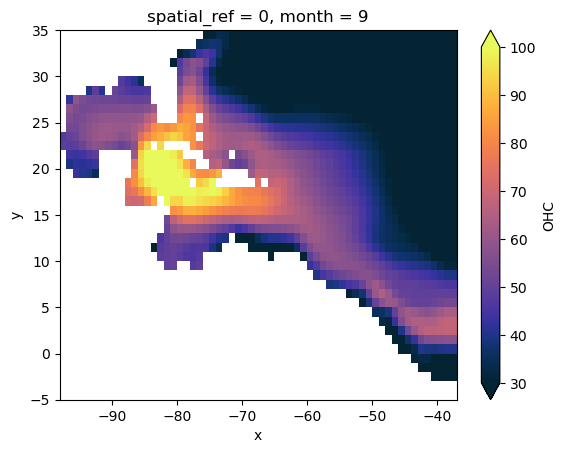

In [37]:
ds.OHC.groupby(ds.time.dt.month).mean().where(ds.OHC.groupby(ds.time.dt.month).mean().month==9,drop=True).plot(cmap=cmo.thermal,vmin=30,vmax=100)

(-90.0, -61.0)

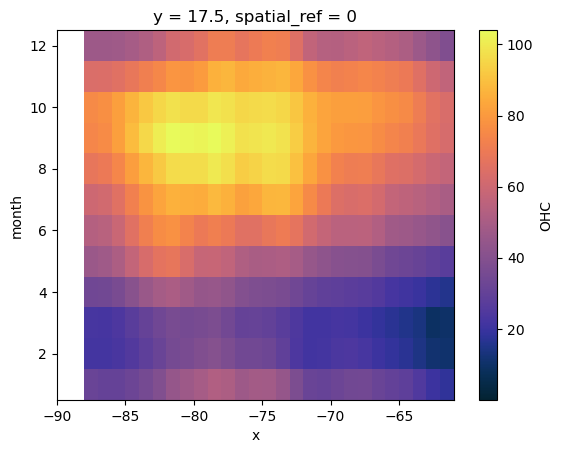

In [32]:
ds.OHC.groupby(ds.time.dt.month).mean().where(ds.y==17.5,drop=True).transpose().plot(cmap=cmo.thermal)
plt.xlim(-90,-61)